In [22]:
from state import State
from langgraph.graph import StateGraph, START, END
import asyncio
from typing import Literal
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt




def linkedin_expert_evaluation(state: State) -> dict:
    """Evaluate the generated post from a LinkedIn expert perspective"""
    return 0


def devops_engineer_evaluation(state: State) -> dict:
    """Evaluate the generated post from a DevOps engineer perspective"""
    return 0

def genai_engineer_evaluation(state: State) -> dict:
    """Evaluate the generated post from a GenAI engineer perspective"""
    return 0
def backend_engineer_evaluation(state: State) -> dict:
    """Evaluate the generated post from a Backend engineer perspective"""
    return 0 


def hiring_manager_evaluation(state: State) -> dict:
    """Evaluate the generated post from a Hiring manager perspective"""
    return 0


def generate_post(state: State) -> State:
    """Generate a LinkedIn post based on user input"""
    return 0

def generate_new_post_with_feedback(state: State) -> State:
    """Generate a LinkedIn post based on user input and feedback"""
    return 0

In [23]:

def human_interupt_confirmation(state: State) -> Command[Literal["human_interrupt_reason", "__end__"]]:
    """
    Pauses execution to ask the user for approval.
    
    - If user resumes with True: Routes to END.
    - If user resumes with False/String: Routes to 'human_interrupt_reason'.
    """

    user_feedback = interrupt({
        "question": "Do you approve the generated post?",
        "post": state["generated_post"],
        "evaluations": state.get("evaluations", {})
    })

    if user_feedback is True:
        return Command(
            update={"human_interrupt_confirmed": True},
            goto="__end__"
        )
    else:
        reason = user_feedback if isinstance(user_feedback, str) else "No reason provided."
        return Command(
            update={
                "evaluations": None,
                "human_interrupt_confirmed": False, 
                "human_interrupt_reason": reason
            },
            goto="human_interrupt_reason"
        )


def human_interupt_reason(state: State) -> State:
    """
    The state is ALREADY filled with the user's input from the previous node.
    We just log it and pass it to the generator.
    """

    reason = state.get("human_interrupt_reason", "No reason provided")
    
    print(f"\n--- PROCESSING FEEDBACK: {reason} ---\n")
    
    return state

async def evaluation_node(state: State) -> State:
    evaluators = state.get("evaluators", [])
    evaluator_map = {
        "linkedin_expert_evaluation": linkedin_expert_evaluation,
        "devops_engineer_evaluation": devops_engineer_evaluation,
        "genai_engineer_evaluation": genai_engineer_evaluation,
        "backend_engineer_evaluation": backend_engineer_evaluation,
        "hiring_manager_evaluation": hiring_manager_evaluation
    }

    tasks = []
    active_evaluator_names = []

    for name in evaluators:
        if name in evaluator_map:
            tasks.append(evaluator_map[name](state["generated_post"]))
            active_evaluator_names.append(name)

    if tasks:
        results = await asyncio.gather(*tasks)
        eval_results = dict(zip(active_evaluator_names, results))
    else:
        eval_results = {}
    
    return {"evaluations": eval_results}


def input_node(state: State) -> State:
    """Entry point / pass-through"""
    return state


def orchestrator_node(state: State) -> Literal["generate", "evaluation_node", "human_bool_interrupt"]:
    if not state.get("generated_post"):
        return "generate"
    
    elif not state.get("evaluations"):
        return "evaluation_node"
    
    else:
        return "human_bool_interrupt"


### 4. Graph Construction ###
graph = StateGraph(State)

graph.add_node("orchestrator", input_node)
graph.add_node("generate", generate_post)
graph.add_node("generate_with_feedback", generate_new_post_with_feedback)
graph.add_node("evaluation_node", evaluation_node)
graph.add_node("human_bool_interrupt", human_interupt_confirmation)
graph.add_node("human_interrupt_reason", human_interupt_reason)


### Graph Edges ###

graph.add_edge(START, "orchestrator")
graph.add_conditional_edges("orchestrator", orchestrator_node, {
    "generate": "generate",
    "evaluation_node": "evaluation_node",
    "human_bool_interrupt": "human_bool_interrupt"
})
graph.add_edge("generate", "orchestrator")
graph.add_edge("generate_with_feedback", "orchestrator")
graph.add_edge("evaluation_node", "orchestrator")
graph.add_edge("human_interrupt_reason", "generate_with_feedback")




checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

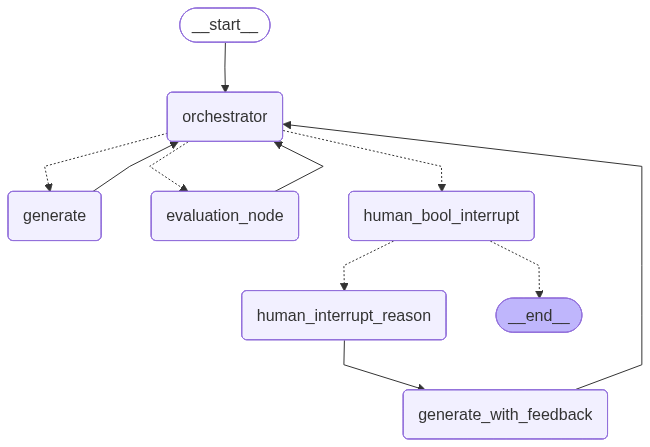

In [24]:
app